In [1]:
#Multiprocessing for Parallelism
from concurrent.futures import ThreadPoolExecutor, as_completed 

# data science
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import random

random.seed(42)
np.random.seed(42)

In [3]:
import calendar

def findDay(date):
	year, month, day = (int(i) for i in date.split('-')) 
	return calendar.weekday(year, month, day)

In [4]:
BASE_PATH = "data/"
data_site_solar_generation_path = BASE_PATH + 'Solar_Generation_sub.csv'
data_site_solar_generation = pd.read_csv(data_site_solar_generation_path)
X = data_site_solar_generation[['Month','Weekday','Hour','Minute','ApparentTemperature','Ghi']].to_numpy()
#X = np.hstack([weather_data["ApparentTemperature"].values.reshape(-1, 1),data_site_solar_generation[['Month','Weekday','Hour','Minute']].values])
print(np.shape(X))
print(type(X))

Y = data_site_solar_generation['SolarGeneration'].to_numpy()
init_Y_len = Y.shape[0]
print(np.shape(Y))
print(type(Y))

(34256, 6)
<class 'numpy.ndarray'>
(34256,)
<class 'numpy.ndarray'>


In [5]:
temp_irra_interpolatiiing_path = BASE_PATH + 'temp_irra_interpolatiiing_with_ghi.csv'
temp_irra_interpolatiiing = pd.read_csv(temp_irra_interpolatiiing_path)

##print("Before: ", X.shape[0])
init_x_len = X.shape[0]
X = np.resize(X,(init_x_len+(24*4),6))
##print("After: ", X.shape[0])

for i in range (24*4):
    X[init_x_len+i][0] = temp_irra_interpolatiiing['time'][i][5:7] # adding the Month
    X[init_x_len+i][1] = findDay(temp_irra_interpolatiiing['time'][i][0:10]) # adding the Weekday
    X[init_x_len+i][2] = temp_irra_interpolatiiing['time'][i][11:13] # adding the Hour
    X[init_x_len+i][3] = temp_irra_interpolatiiing['time'][i][14:16] # adding the Hour
    X[init_x_len+i][4] = temp_irra_interpolatiiing['temperature'][i] # adding the temperature to X data
    X[init_x_len+i][5] = temp_irra_interpolatiiing['GHI_est'][i] # adding the ghi
    #print(X[init_x_len+i])

Y = np.resize(Y,(init_Y_len+(24*4),1))

In [6]:
# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle = False ) #, random_state=42
X_train2, X_val, Y_train2, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle = False ) #, random_state=42
print("Train: ", np.max(X_train), " ", (X_train.shape))
#print("Val: ", np.max(X_val), " ", (X_val.shape))
print("Test: ", np.max(X_test), " ", (X_test.shape))
len_of_x_test_original = X_test.shape[0] - (24*4)

# Fit scaler only on training data
scaler_X = StandardScaler()
# Scale the labels (optional, depending on your case)
scaler_Y = StandardScaler()

X_test_original = (X_test)
Y_test_original = (Y_test)

Train:  1078.0   (27481, 6)
Test:  1091.0   (6871, 6)


In [7]:
'''
# --- Step 1: Scaling X and Y ---
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

# --- Step 2: Sequence Creation ---
def create_sequences(X, Y, sequence_length):
    X_seq, Y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        Y_seq.append(Y[i+sequence_length])
    return np.array(X_seq), np.array(Y_seq)

sequence_length = 10
X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, sequence_length)

# Reshape Y_seq
Y_seq = Y_seq.reshape(-1, 1)

# --- Step 3: Train/Val/Test Split ---
split_1 = int(len(X_seq) * 0.6)
split_2 = int(len(X_seq) * 0.8)

X_train, Y_train = X_seq[:split_1], Y_seq[:split_1]
X_val, Y_val = X_seq[split_1:split_2], Y_seq[split_1:split_2]
X_test, Y_test = X_seq[split_2:], Y_seq[split_2:]

# --- Step 4: Partition training data into clients (4 clients) ---
client_size = len(X_train) // 4
clients = [
    (X_train[i * client_size:(i + 1) * client_size],
     Y_train[i * client_size:(i + 1) * client_size])
    for i in range(4)
]'''
# Reshape for LSTM (samples, timesteps, features)
'''X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))'''

'X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))\nX_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))'

In [8]:
import tensorflow
from tensorflow.keras.models import Sequential, save_model, load_model, clone_model
from tensorflow.keras import Input
from keras import activations
from tensorflow.keras import backend
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dense, InputLayer, Lambda, BatchNormalization,TimeDistributed, RepeatVector, Activation, MaxPooling1D
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential([
    Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(1,6)),
    MaxPooling1D(1),
    LSTM(50),
    Dense(1, kernel_regularizer="l2")
    ])
    return model

def train_client_proc(server_weights, client_data_tuple):
    # Create and build client model
    model = create_model()
    model.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))
    model.set_weights(server_weights)

    (x, y, x_val, y_val) = client_data_tuple
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(x, y, validation_data=(x_val, y_val), epochs=5, batch_size=32, callbacks=[early_stop], verbose=0)

    return model.get_weights()

In [9]:
num_of_clients = 1
max_workers = 1
c_x = np.array_split(X_train, num_of_clients)
c_y = np.array_split(Y_train, num_of_clients)

c_x_val = np.array_split(X_val, num_of_clients)
c_y_val = np.array_split(Y_val, num_of_clients)

# --- Prepare data for each client ---
# Assuming c1_x, c2_x, ..., are already split and in shape (samples, 6)
# Reshape to (samples, 1, features)
def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )
c_x_reshaped = []
c_x_val_reshaped = []
c_x_scaled = []
c_x_val_scaled = []
c_y_scaled = []
c_y_val_scaled = []

client_data = []
client_weights = []

for i in range(num_of_clients):
    # Reshape x to 2D for scaling
    c_x_reshaped.append(c_x[i].reshape(-1, c_x[i].shape[-1])) 
    c_x_val_reshaped.append(c_x_val[i].reshape(-1, c_x_val[i].shape[-1]))
    # Apply standard scaling
    c_x_scaled.append(scaler_X.fit_transform(c_x_reshaped[i]))
    c_x_val_scaled.append(scaler_X.transform(c_x_val_reshaped[i]))
    # Scale y if needed
    c_y_scaled.append(scaler_Y.fit_transform(c_y[i]))
    c_y_val_scaled.append(scaler_Y.transform(c_y_val[i]))
    c_x[i], c_y[i], c_x_val[i], c_y_val[i] = reshape_client_data(c_x_scaled[i], c_y_scaled[i], c_x_val_scaled[i], c_y_val_scaled[i])
    
    client_data.append((c_x[i], c_y[i], c_x_val[i], c_y_val[i]))

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
# --- Server model & clients ---
model_server = create_model()
model_server.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# --- Training rounds ---
mae_list_fl_1_prosum_1_vCPU = []
rounds = 6
for i in range(rounds):
    print(f'\n--- Round {i+1} ---')

    # Get current weights from server
    server_weights = model_server.get_weights()

    # Train all clients in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, server_weights, client_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_weights.append(f.result())

    # Aggregate weights
    avg_weights = [
        np.mean([weights[k] for weights in client_weights], axis=0)
        for k in range(len(server_weights))
    ]
    model_server.set_weights(avg_weights)

    # Prediction
    X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
    Y_predict_fl_scaled = model_server.predict(X_test_reshaped)
    Y_predict_fl_1_prosum_1_vCPU = scaler_Y.inverse_transform(Y_predict_fl_scaled.reshape(-1, 1))
    Y_predict_fl_1_prosum_1_vCPU = np.where(Y_predict_fl_1_prosum_1_vCPU >= 0.0, Y_predict_fl_1_prosum_1_vCPU, 0)

    mae = mean_absolute_error(Y_test_original, Y_predict_fl_1_prosum_1_vCPU)
    mae_list_fl_1_prosum_1_vCPU.append(mae)
    print(f'MAE: {mae:.3f}')


--- Round 1 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 8.111

--- Round 2 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
MAE: 7.972

--- Round 3 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
MAE: 8.023

--- Round 4 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
MAE: 8.052

--- Round 5 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
MAE: 7.996

--- Round 6 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
MAE: 7.987


In [10]:
num_of_clients = 2
max_workers = 1
c_x = np.array_split(X_train, num_of_clients)
c_y = np.array_split(Y_train, num_of_clients)

c_x_val = np.array_split(X_val, num_of_clients)
c_y_val = np.array_split(Y_val, num_of_clients)

# --- Prepare data for each client ---
# Assuming c1_x, c2_x, ..., are already split and in shape (samples, 6)
# Reshape to (samples, 1, features)
def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )
c_x_reshaped = []
c_x_val_reshaped = []
c_x_scaled = []
c_x_val_scaled = []
c_y_scaled = []
c_y_val_scaled = []

client_data = []
client_weights = []

for i in range(num_of_clients):
    # Reshape x to 2D for scaling
    c_x_reshaped.append(c_x[i].reshape(-1, c_x[i].shape[-1])) 
    c_x_val_reshaped.append(c_x_val[i].reshape(-1, c_x_val[i].shape[-1]))
    # Apply standard scaling
    c_x_scaled.append(scaler_X.fit_transform(c_x_reshaped[i]))
    c_x_val_scaled.append(scaler_X.transform(c_x_val_reshaped[i]))
    # Scale y if needed
    c_y_scaled.append(scaler_Y.fit_transform(c_y[i]))
    c_y_val_scaled.append(scaler_Y.transform(c_y_val[i]))
    c_x[i], c_y[i], c_x_val[i], c_y_val[i] = reshape_client_data(c_x_scaled[i], c_y_scaled[i], c_x_val_scaled[i], c_y_val_scaled[i])
    
    client_data.append((c_x[i], c_y[i], c_x_val[i], c_y_val[i]))

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
# --- Server model & clients ---
model_server = create_model()
model_server.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# --- Training rounds ---
mae_list_fl_2_prosum_1_vCPU = []
rounds = 6
for i in range(rounds):
    print(f'\n--- Round {i+1} ---')

    # Get current weights from server
    server_weights = model_server.get_weights()

    # Train all clients in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, server_weights, client_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_weights.append(f.result())

    # Aggregate weights
    avg_weights = [
        np.mean([weights[k] for weights in client_weights], axis=0)
        for k in range(len(server_weights))
    ]
    model_server.set_weights(avg_weights)

    # Prediction
    X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
    Y_predict_fl_scaled = model_server.predict(X_test_reshaped)
    Y_predict_fl_2_prosum_1_vCPU = scaler_Y.inverse_transform(Y_predict_fl_scaled.reshape(-1, 1))
    Y_predict_fl_2_prosum_1_vCPU = np.where(Y_predict_fl_2_prosum_1_vCPU >= 0.0, Y_predict_fl_2_prosum_1_vCPU, 0)

    mae = mean_absolute_error(Y_test_original, Y_predict_fl_2_prosum_1_vCPU)
    mae_list_fl_2_prosum_1_vCPU.append(mae)
    print(f'MAE: {mae:.3f}')


--- Round 1 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 7.731

--- Round 2 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
MAE: 7.663

--- Round 3 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
MAE: 7.589

--- Round 4 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 7.530

--- Round 5 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 7.545

--- Round 6 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 7.529


In [11]:
num_of_clients = 4
max_workers = 1
c_x = np.array_split(X_train, num_of_clients)
c_y = np.array_split(Y_train, num_of_clients)

c_x_val = np.array_split(X_val, num_of_clients)
c_y_val = np.array_split(Y_val, num_of_clients)

# --- Prepare data for each client ---
# Assuming c1_x, c2_x, ..., are already split and in shape (samples, 6)
# Reshape to (samples, 1, features)
def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )
c_x_reshaped = []
c_x_val_reshaped = []
c_x_scaled = []
c_x_val_scaled = []
c_y_scaled = []
c_y_val_scaled = []

client_data = []
client_weights = []

for i in range(num_of_clients):
    # Reshape x to 2D for scaling
    c_x_reshaped.append(c_x[i].reshape(-1, c_x[i].shape[-1])) 
    c_x_val_reshaped.append(c_x_val[i].reshape(-1, c_x_val[i].shape[-1]))
    # Apply standard scaling
    c_x_scaled.append(scaler_X.fit_transform(c_x_reshaped[i]))
    c_x_val_scaled.append(scaler_X.transform(c_x_val_reshaped[i]))
    # Scale y if needed
    c_y_scaled.append(scaler_Y.fit_transform(c_y[i]))
    c_y_val_scaled.append(scaler_Y.transform(c_y_val[i]))
    c_x[i], c_y[i], c_x_val[i], c_y_val[i] = reshape_client_data(c_x_scaled[i], c_y_scaled[i], c_x_val_scaled[i], c_y_val_scaled[i])
    
    client_data.append((c_x[i], c_y[i], c_x_val[i], c_y_val[i]))

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
# --- Server model & clients ---
model_server = create_model()
model_server.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# --- Training rounds ---
mae_list_fl_4_prosum_1_vCPU = []
rounds = 6
for i in range(rounds):
    print(f'\n--- Round {i+1} ---')

    # Get current weights from server
    server_weights = model_server.get_weights()

    # Train all clients in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, server_weights, client_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_weights.append(f.result())

    # Aggregate weights
    avg_weights = [
        np.mean([weights[k] for weights in client_weights], axis=0)
        for k in range(len(server_weights))
    ]
    model_server.set_weights(avg_weights)

    # Prediction
    X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
    Y_predict_fl_scaled = model_server.predict(X_test_reshaped)
    Y_predict_fl_4_prosum_1_vCPU = scaler_Y.inverse_transform(Y_predict_fl_scaled.reshape(-1, 1))
    Y_predict_fl_4_prosum_1_vCPU = np.where(Y_predict_fl_4_prosum_1_vCPU >= 0.0, Y_predict_fl_4_prosum_1_vCPU, 0)

    mae = mean_absolute_error(Y_test_original, Y_predict_fl_4_prosum_1_vCPU)
    mae_list_fl_4_prosum_1_vCPU.append(mae)
    print(f'MAE: {mae:.3f}')


--- Round 1 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 8.103

--- Round 2 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 7.409

--- Round 3 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
MAE: 7.119

--- Round 4 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
MAE: 7.011

--- Round 5 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
MAE: 6.926

--- Round 6 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
MAE: 6.872


In [12]:
num_of_clients = 4
max_workers = 4
c_x = np.array_split(X_train, num_of_clients)
c_y = np.array_split(Y_train, num_of_clients)

c_x_val = np.array_split(X_val, num_of_clients)
c_y_val = np.array_split(Y_val, num_of_clients)

# --- Prepare data for each client ---
# Assuming c1_x, c2_x, ..., are already split and in shape (samples, 6)
# Reshape to (samples, 1, features)
def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )
c_x_reshaped = []
c_x_val_reshaped = []
c_x_scaled = []
c_x_val_scaled = []
c_y_scaled = []
c_y_val_scaled = []

client_data = []
client_weights = []

for i in range(num_of_clients):
    # Reshape x to 2D for scaling
    c_x_reshaped.append(c_x[i].reshape(-1, c_x[i].shape[-1])) 
    c_x_val_reshaped.append(c_x_val[i].reshape(-1, c_x_val[i].shape[-1]))
    # Apply standard scaling
    c_x_scaled.append(scaler_X.fit_transform(c_x_reshaped[i]))
    c_x_val_scaled.append(scaler_X.transform(c_x_val_reshaped[i]))
    # Scale y if needed
    c_y_scaled.append(scaler_Y.fit_transform(c_y[i]))
    c_y_val_scaled.append(scaler_Y.transform(c_y_val[i]))
    c_x[i], c_y[i], c_x_val[i], c_y_val[i] = reshape_client_data(c_x_scaled[i], c_y_scaled[i], c_x_val_scaled[i], c_y_val_scaled[i])
    
    client_data.append((c_x[i], c_y[i], c_x_val[i], c_y_val[i]))

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
# --- Server model & clients ---
model_server = create_model()
model_server.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# --- Training rounds ---
mae_list_fl_4_prosum_4_vCPU = []
rounds = 6
for i in range(rounds):
    print(f'\n--- Round {i+1} ---')

    # Get current weights from server
    server_weights = model_server.get_weights()

    # Train all clients in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, server_weights, client_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_weights.append(f.result())

    # Aggregate weights
    avg_weights = [
        np.mean([weights[k] for weights in client_weights], axis=0)
        for k in range(len(server_weights))
    ]
    model_server.set_weights(avg_weights)

    # Prediction
    X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
    Y_predict_fl_scaled = model_server.predict(X_test_reshaped)
    Y_predict_fl_4_prosum_4_vCPU = scaler_Y.inverse_transform(Y_predict_fl_scaled.reshape(-1, 1))
    Y_predict_fl_4_prosum_4_vCPU = np.where(Y_predict_fl_4_prosum_4_vCPU >= 0.0, Y_predict_fl_4_prosum_4_vCPU, 0)

    mae = mean_absolute_error(Y_test_original, Y_predict_fl_4_prosum_4_vCPU)
    mae_list_fl_4_prosum_4_vCPU.append(mae)
    print(f'MAE: {mae:.3f}')


--- Round 1 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 12.215

--- Round 2 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
MAE: 10.839

--- Round 3 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
MAE: 9.921

--- Round 4 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 9.310

--- Round 5 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 8.855

--- Round 6 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 8.536


In [13]:
num_of_clients = 6
max_workers = 6
c_x = np.array_split(X_train, num_of_clients)
c_y = np.array_split(Y_train, num_of_clients)

c_x_val = np.array_split(X_val, num_of_clients)
c_y_val = np.array_split(Y_val, num_of_clients)

# --- Prepare data for each client ---
# Assuming c1_x, c2_x, ..., are already split and in shape (samples, 6)
# Reshape to (samples, 1, features)
def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )
c_x_reshaped = []
c_x_val_reshaped = []
c_x_scaled = []
c_x_val_scaled = []
c_y_scaled = []
c_y_val_scaled = []

client_data = []
client_weights = []

for i in range(num_of_clients):
    # Reshape x to 2D for scaling
    c_x_reshaped.append(c_x[i].reshape(-1, c_x[i].shape[-1])) 
    c_x_val_reshaped.append(c_x_val[i].reshape(-1, c_x_val[i].shape[-1]))
    # Apply standard scaling
    c_x_scaled.append(scaler_X.fit_transform(c_x_reshaped[i]))
    c_x_val_scaled.append(scaler_X.transform(c_x_val_reshaped[i]))
    # Scale y if needed
    c_y_scaled.append(scaler_Y.fit_transform(c_y[i]))
    c_y_val_scaled.append(scaler_Y.transform(c_y_val[i]))
    c_x[i], c_y[i], c_x_val[i], c_y_val[i] = reshape_client_data(c_x_scaled[i], c_y_scaled[i], c_x_val_scaled[i], c_y_val_scaled[i])
    
    client_data.append((c_x[i], c_y[i], c_x_val[i], c_y_val[i]))

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
# --- Server model & clients ---
model_server = create_model()
model_server.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# --- Training rounds ---
mae_list_fl_6_prosum_6_vCPU = []
rounds = 6
for i in range(rounds):
    print(f'\n--- Round {i+1} ---')

    # Get current weights from server
    server_weights = model_server.get_weights()

    # Train all clients in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, server_weights, client_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_weights.append(f.result())

    # Aggregate weights
    avg_weights = [
        np.mean([weights[k] for weights in client_weights], axis=0)
        for k in range(len(server_weights))
    ]
    model_server.set_weights(avg_weights)

    # Prediction
    X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
    Y_predict_fl_scaled = model_server.predict(X_test_reshaped)
    Y_predict_fl_6_prosum_6_vCPU = scaler_Y.inverse_transform(Y_predict_fl_scaled.reshape(-1, 1))
    Y_predict_fl_6_prosum_6_vCPU = np.where(Y_predict_fl_6_prosum_6_vCPU >= 0.0, Y_predict_fl_6_prosum_6_vCPU, 0)

    mae = mean_absolute_error(Y_test_original, Y_predict_fl_6_prosum_6_vCPU)
    mae_list_fl_6_prosum_6_vCPU.append(mae)
    print(f'MAE: {mae:.3f}')


--- Round 1 ---


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 13.020

--- Round 2 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 12.409

--- Round 3 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 12.125

--- Round 4 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 12.021

--- Round 5 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 11.972

--- Round 6 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 11.917


In [14]:
num_of_clients = 8
max_workers = 8
c_x = np.array_split(X_train, num_of_clients)
c_y = np.array_split(Y_train, num_of_clients)

c_x_val = np.array_split(X_val, num_of_clients)
c_y_val = np.array_split(Y_val, num_of_clients)

# --- Prepare data for each client ---
# Assuming c1_x, c2_x, ..., are already split and in shape (samples, 6)
# Reshape to (samples, 1, features)
def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )
c_x_reshaped = []
c_x_val_reshaped = []
c_x_scaled = []
c_x_val_scaled = []
c_y_scaled = []
c_y_val_scaled = []

client_data = []
client_weights = []

for i in range(num_of_clients):
    # Reshape x to 2D for scaling
    c_x_reshaped.append(c_x[i].reshape(-1, c_x[i].shape[-1])) 
    c_x_val_reshaped.append(c_x_val[i].reshape(-1, c_x_val[i].shape[-1]))
    # Apply standard scaling
    c_x_scaled.append(scaler_X.fit_transform(c_x_reshaped[i]))
    c_x_val_scaled.append(scaler_X.transform(c_x_val_reshaped[i]))
    # Scale y if needed
    c_y_scaled.append(scaler_Y.fit_transform(c_y[i]))
    c_y_val_scaled.append(scaler_Y.transform(c_y_val[i]))
    c_x[i], c_y[i], c_x_val[i], c_y_val[i] = reshape_client_data(c_x_scaled[i], c_y_scaled[i], c_x_val_scaled[i], c_y_val_scaled[i])
    
    client_data.append((c_x[i], c_y[i], c_x_val[i], c_y_val[i]))

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
# --- Server model & clients ---
model_server = create_model()
model_server.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# --- Training rounds ---
mae_list_fl_8_prosum_8_vCPU = []
rounds = 6
for i in range(rounds):
    print(f'\n--- Round {i+1} ---')

    # Get current weights from server
    server_weights = model_server.get_weights()

    # Train all clients in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, server_weights, client_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_weights.append(f.result())

    # Aggregate weights
    avg_weights = [
        np.mean([weights[k] for weights in client_weights], axis=0)
        for k in range(len(server_weights))
    ]
    model_server.set_weights(avg_weights)

    # Prediction
    X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
    Y_predict_fl_scaled = model_server.predict(X_test_reshaped)
    Y_predict_fl_8_prosum_8_vCPU = scaler_Y.inverse_transform(Y_predict_fl_scaled.reshape(-1, 1))
    Y_predict_fl_8_prosum_8_vCPU = np.where(Y_predict_fl_8_prosum_8_vCPU >= 0.0, Y_predict_fl_8_prosum_8_vCPU, 0)

    mae = mean_absolute_error(Y_test_original, Y_predict_fl_8_prosum_8_vCPU)
    mae_list_fl_8_prosum_8_vCPU.append(mae)
    print(f'MAE: {mae:.3f}')


--- Round 1 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 12.180

--- Round 2 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 11.680

--- Round 3 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 11.442

--- Round 4 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 11.211

--- Round 5 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 11.068

--- Round 6 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 10.923


In [15]:
num_of_clients = 10
max_workers = 8
c_x = np.array_split(X_train, num_of_clients)
c_y = np.array_split(Y_train, num_of_clients)

c_x_val = np.array_split(X_val, num_of_clients)
c_y_val = np.array_split(Y_val, num_of_clients)

# --- Prepare data for each client ---
# Assuming c1_x, c2_x, ..., are already split and in shape (samples, 6)
# Reshape to (samples, 1, features)
def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )
c_x_reshaped = []
c_x_val_reshaped = []
c_x_scaled = []
c_x_val_scaled = []
c_y_scaled = []
c_y_val_scaled = []

client_data = []
client_weights = []

for i in range(num_of_clients):
    # Reshape x to 2D for scaling
    c_x_reshaped.append(c_x[i].reshape(-1, c_x[i].shape[-1])) 
    c_x_val_reshaped.append(c_x_val[i].reshape(-1, c_x_val[i].shape[-1]))
    # Apply standard scaling
    c_x_scaled.append(scaler_X.fit_transform(c_x_reshaped[i]))
    c_x_val_scaled.append(scaler_X.transform(c_x_val_reshaped[i]))
    # Scale y if needed
    c_y_scaled.append(scaler_Y.fit_transform(c_y[i]))
    c_y_val_scaled.append(scaler_Y.transform(c_y_val[i]))
    c_x[i], c_y[i], c_x_val[i], c_y_val[i] = reshape_client_data(c_x_scaled[i], c_y_scaled[i], c_x_val_scaled[i], c_y_val_scaled[i])
    
    client_data.append((c_x[i], c_y[i], c_x_val[i], c_y_val[i]))

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
# --- Server model & clients ---
model_server = create_model()
model_server.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# --- Training rounds ---
mae_list_fl_10_prosum_8_vCPU = []
rounds = 6
for i in range(rounds):
    print(f'\n--- Round {i+1} ---')

    # Get current weights from server
    server_weights = model_server.get_weights()

    # Train all clients in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, server_weights, client_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_weights.append(f.result())

    # Aggregate weights
    avg_weights = [
        np.mean([weights[k] for weights in client_weights], axis=0)
        for k in range(len(server_weights))
    ]
    model_server.set_weights(avg_weights)

    # Prediction
    X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
    Y_predict_fl_scaled = model_server.predict(X_test_reshaped)
    Y_predict_fl_10_prosum_8_vCPU = scaler_Y.inverse_transform(Y_predict_fl_scaled.reshape(-1, 1))
    Y_predict_fl_10_prosum_8_vCPU = np.where(Y_predict_fl_10_prosum_8_vCPU >= 0.0, Y_predict_fl_10_prosum_8_vCPU, 0)

    mae = mean_absolute_error(Y_test_original, Y_predict_fl_10_prosum_8_vCPU)
    mae_list_fl_10_prosum_8_vCPU.append(mae)
    print(f'MAE: {mae:.3f}')


--- Round 1 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 15.296

--- Round 2 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 14.421

--- Round 3 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 14.081

--- Round 4 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 13.816

--- Round 5 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 13.665

--- Round 6 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
MAE: 13.580


In [16]:
num_of_clients = 10
max_workers = 10
c_x = np.array_split(X_train, num_of_clients)
c_y = np.array_split(Y_train, num_of_clients)

c_x_val = np.array_split(X_val, num_of_clients)
c_y_val = np.array_split(Y_val, num_of_clients)

# --- Prepare data for each client ---
# Assuming c1_x, c2_x, ..., are already split and in shape (samples, 6)
# Reshape to (samples, 1, features)
def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )
c_x_reshaped = []
c_x_val_reshaped = []
c_x_scaled = []
c_x_val_scaled = []
c_y_scaled = []
c_y_val_scaled = []

client_data = []
client_weights = []

for i in range(num_of_clients):
    # Reshape x to 2D for scaling
    c_x_reshaped.append(c_x[i].reshape(-1, c_x[i].shape[-1])) 
    c_x_val_reshaped.append(c_x_val[i].reshape(-1, c_x_val[i].shape[-1]))
    # Apply standard scaling
    c_x_scaled.append(scaler_X.fit_transform(c_x_reshaped[i]))
    c_x_val_scaled.append(scaler_X.transform(c_x_val_reshaped[i]))
    # Scale y if needed
    c_y_scaled.append(scaler_Y.fit_transform(c_y[i]))
    c_y_val_scaled.append(scaler_Y.transform(c_y_val[i]))
    c_x[i], c_y[i], c_x_val[i], c_y_val[i] = reshape_client_data(c_x_scaled[i], c_y_scaled[i], c_x_val_scaled[i], c_y_val_scaled[i])
    
    client_data.append((c_x[i], c_y[i], c_x_val[i], c_y_val[i]))

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
# --- Server model & clients ---
model_server = create_model()
model_server.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# --- Training rounds ---
mae_list_fl_10_prosum_10_vCPU = []
rounds = 6
for i in range(rounds):
    print(f'\n--- Round {i+1} ---')

    # Get current weights from server
    server_weights = model_server.get_weights()

    # Train all clients in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, server_weights, client_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_weights.append(f.result())

    # Aggregate weights
    avg_weights = [
        np.mean([weights[k] for weights in client_weights], axis=0)
        for k in range(len(server_weights))
    ]
    model_server.set_weights(avg_weights)

    # Prediction
    X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
    Y_predict_fl_scaled = model_server.predict(X_test_reshaped)
    Y_predict_fl_10_prosum_10_vCPU = scaler_Y.inverse_transform(Y_predict_fl_scaled.reshape(-1, 1))
    Y_predict_fl_10_prosum_10_vCPU = np.where(Y_predict_fl_10_prosum_10_vCPU >= 0.0, Y_predict_fl_10_prosum_10_vCPU, 0)

    mae = mean_absolute_error(Y_test_original, Y_predict_fl_10_prosum_10_vCPU)
    mae_list_fl_10_prosum_10_vCPU.append(mae)
    print(f'MAE: {mae:.3f}')


--- Round 1 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 13.233

--- Round 2 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
MAE: 11.989

--- Round 3 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 11.358

--- Round 4 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
MAE: 10.950

--- Round 5 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 10.607

--- Round 6 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 10.337


In [17]:
num_of_clients = 12
max_workers = 12
c_x = np.array_split(X_train, num_of_clients)
c_y = np.array_split(Y_train, num_of_clients)

c_x_val = np.array_split(X_val, num_of_clients)
c_y_val = np.array_split(Y_val, num_of_clients)

# --- Prepare data for each client ---
# Assuming c1_x, c2_x, ..., are already split and in shape (samples, 6)
# Reshape to (samples, 1, features)
def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )
c_x_reshaped = []
c_x_val_reshaped = []
c_x_scaled = []
c_x_val_scaled = []
c_y_scaled = []
c_y_val_scaled = []

client_data = []
client_weights = []

for i in range(num_of_clients):
    # Reshape x to 2D for scaling
    c_x_reshaped.append(c_x[i].reshape(-1, c_x[i].shape[-1])) 
    c_x_val_reshaped.append(c_x_val[i].reshape(-1, c_x_val[i].shape[-1]))
    # Apply standard scaling
    c_x_scaled.append(scaler_X.fit_transform(c_x_reshaped[i]))
    c_x_val_scaled.append(scaler_X.transform(c_x_val_reshaped[i]))
    # Scale y if needed
    c_y_scaled.append(scaler_Y.fit_transform(c_y[i]))
    c_y_val_scaled.append(scaler_Y.transform(c_y_val[i]))
    c_x[i], c_y[i], c_x_val[i], c_y_val[i] = reshape_client_data(c_x_scaled[i], c_y_scaled[i], c_x_val_scaled[i], c_y_val_scaled[i])
    
    client_data.append((c_x[i], c_y[i], c_x_val[i], c_y_val[i]))

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
# --- Server model & clients ---
model_server = create_model()
model_server.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# --- Training rounds ---
mae_list_fl_12_prosum_12_vCPU = []
rounds = 6
for i in range(rounds):
    print(f'\n--- Round {i+1} ---')

    # Get current weights from server
    server_weights = model_server.get_weights()

    # Train all clients in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, server_weights, client_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_weights.append(f.result())

    # Aggregate weights
    avg_weights = [
        np.mean([weights[k] for weights in client_weights], axis=0)
        for k in range(len(server_weights))
    ]
    model_server.set_weights(avg_weights)

    # Prediction
    X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
    Y_predict_fl_scaled = model_server.predict(X_test_reshaped)
    Y_predict_fl_12_prosum_12_vCPU = scaler_Y.inverse_transform(Y_predict_fl_scaled.reshape(-1, 1))
    Y_predict_fl_12_prosum_12_vCPU = np.where(Y_predict_fl_12_prosum_12_vCPU >= 0.0, Y_predict_fl_12_prosum_12_vCPU, 0)

    mae = mean_absolute_error(Y_test_original, Y_predict_fl_12_prosum_12_vCPU)
    mae_list_fl_12_prosum_12_vCPU.append(mae)
    print(f'MAE: {mae:.3f}')


--- Round 1 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 13.359

--- Round 2 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 11.888

--- Round 3 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
MAE: 11.190

--- Round 4 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 10.813

--- Round 5 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 10.572

--- Round 6 ---
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 10.384


### Centralized

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reshape x to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

# Apply standard scaling
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_test_scaled = scaler_X.transform(X_test_reshaped)
X_val_scaled = scaler_X.transform(X_val_reshaped)

# Scale y if needed
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_val_scaled = scaler_Y.transform(Y_val)

cent_x, cent_y, cent_x_val, cent_y_val = reshape_client_data (X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled)
model_lstm = create_model()
model_lstm.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# Summary the model to see if all layers are well combinated.
#model_lstm.summary()

# validation_split = 0.2 : 20% of X_train and y_train are using to test your model
history =  model_lstm.fit(cent_x, cent_y, validation_data=(cent_x_val, cent_y_val), epochs=6, batch_size=32, callbacks=[early_stop], verbose=0)

X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
Y_predict_lstm_scaled = model_lstm.predict(X_test_reshaped) # scale the data with the max_value of the training
Y_predict_lstm = scaler_Y.inverse_transform(Y_predict_lstm_scaled.reshape(-1, 1)) # Inverse transform the predictions and the actual Y_test to get back to the original scale
Y_predict_lstm = np.where(Y_predict_lstm>=0.0, Y_predict_lstm, 0)

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


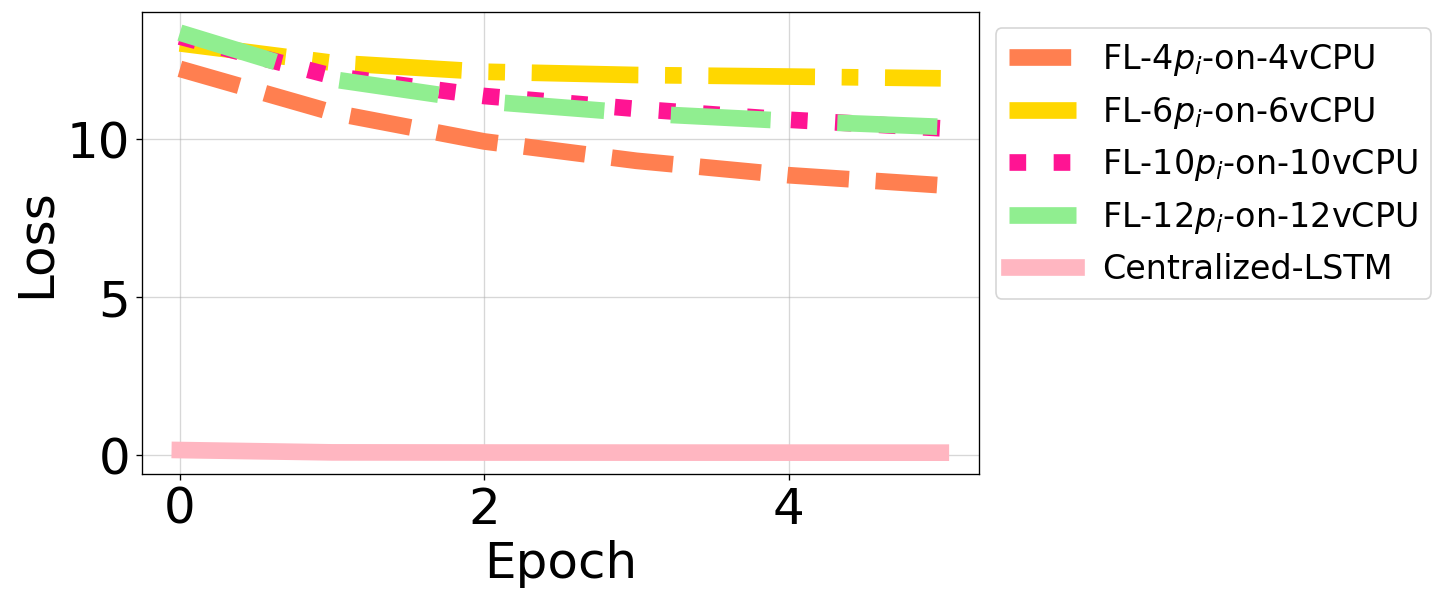

In [153]:
patterns = ['--', '-.', ':', 'dashdot', 'dashed']  # Different hatching styles

fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=30)
#plt.plot(mae_list_fl_1_prosum_1_vCPU, marker='*', color = 'violet', linewidth=10 , label = "FL-2$p_i$-on-1vCPU")
#plt.plot(mae_list_fl_2_prosum_1_vCPU, marker='*', color = 'peachpuff', linewidth=10 , label = "FL-2$p_i$-on-1vCPU")
#plt.plot(mae_list_fl_4_prosum_1_vCPU, marker='*', color = 'lightblue', linewidth=10 , label = "FL-4$p_i$-on-1vCPU")
plt.plot(mae_list_fl_4_prosum_4_vCPU,  linestyle=patterns[0],  color = 'coral', linewidth=10 , label = "FL-4$p_i$-on-4vCPU")
plt.plot(mae_list_fl_6_prosum_6_vCPU,  linestyle=patterns[1], color = 'gold', linewidth=10 , label = "FL-6$p_i$-on-6vCPU")
#plt.plot(mae_list_fl_8_prosum_8_vCPU, marker='*', color = 'mediumblue', linewidth=10 , label = "FL-8$p_i$-on-8vCPU")
#plt.plot(mae_list_fl_10_prosum_8_vCPU, marker='*', color = 'yellowgreen', linewidth=10 , label = "FL-10$p_i$-on-8vCPU")
plt.plot(mae_list_fl_10_prosum_10_vCPU, linestyle=patterns[2],  color = 'deeppink', linewidth=10 , label = "FL-10$p_i$-on-10vCPU")
plt.plot(mae_list_fl_12_prosum_12_vCPU,  linestyle=(0, (6, 4)),  color = 'lightgreen', linewidth=10 , label = "FL-12$p_i$-on-12vCPU")
plt.plot(history.history['loss'],  linestyle='solid',  color='lightpink', linewidth=10, label = "Centralized-LSTM")
plt.xlabel("Epoch", fontsize=30)    
plt.ylabel("Loss", fontsize=30)
plt.legend(bbox_to_anchor =(1,1),fontsize=20)
ax.grid(True, alpha=0.5)
plt.savefig("lstm_fl_validation.pdf", format="pdf", bbox_inches="tight")

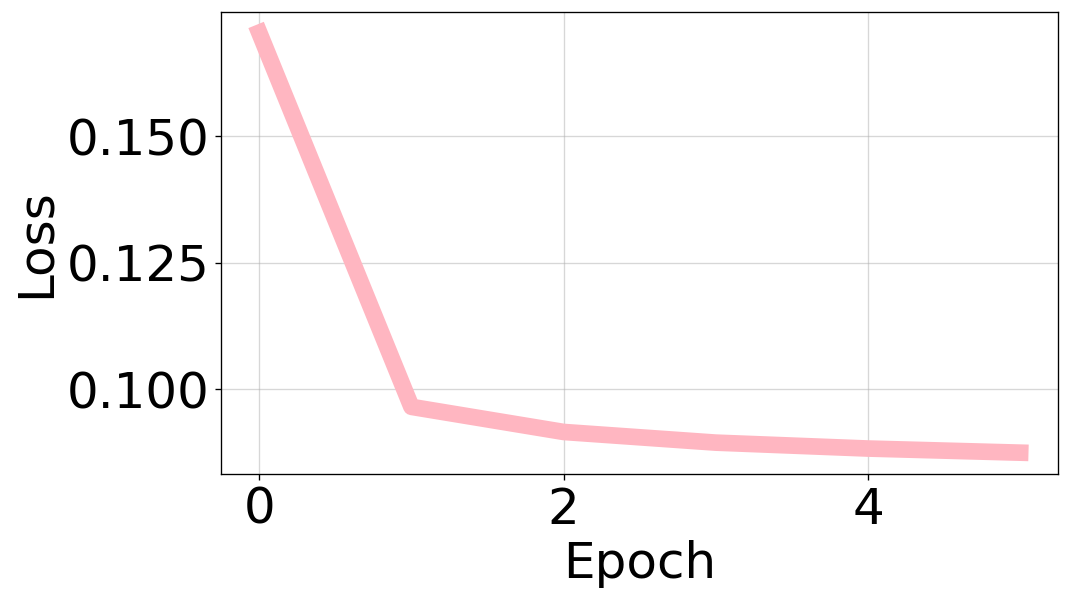

In [154]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=30)
#plt.plot(mae_list, marker='*', color = 'lightblue', linewidth=10 , label = "Federated Learning")
plt.plot(history.history['loss'], marker='+', color='lightpink', linewidth=10)
plt.xlabel("Epoch", fontsize=30)
plt.ylabel("Loss", fontsize=30)
#plt.legend(fontsize=30)
ax.grid(True, alpha=0.5)
plt.savefig("lstm_validation.pdf", format="pdf", bbox_inches="tight")

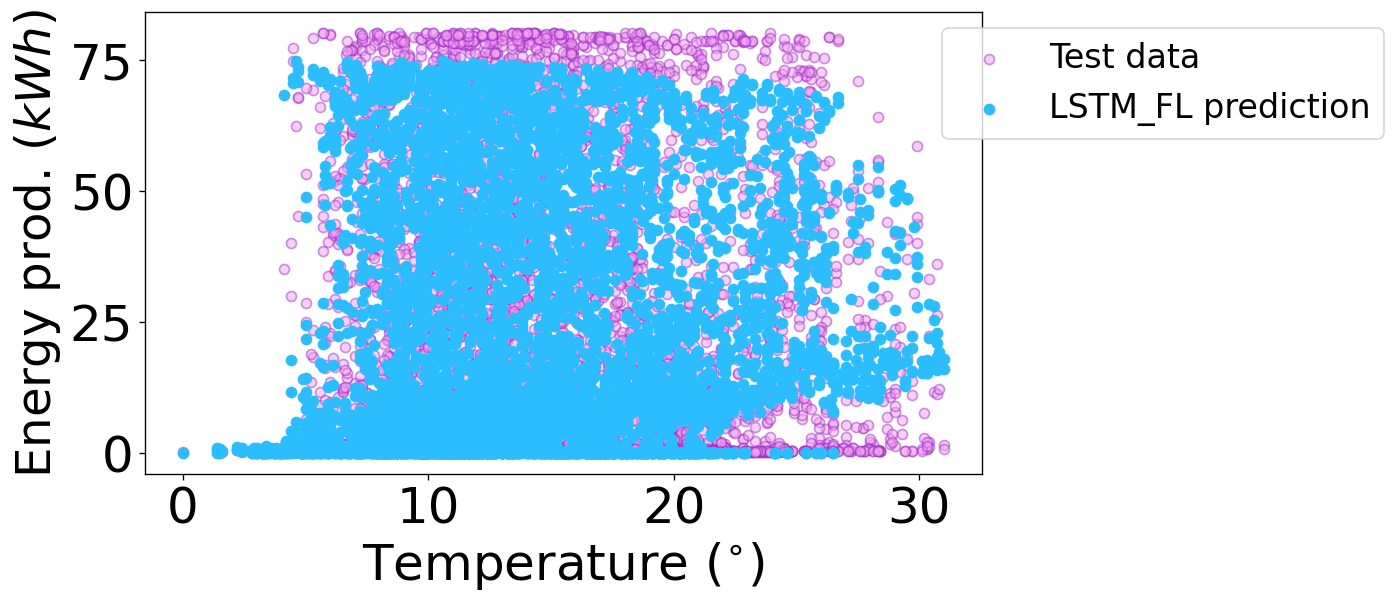

In [155]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test_original))[:,4], y=(Y_test_original), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test_original))[:,4], y=Y_predict_fl_1_prosum_1_vCPU, color="#2CBDFE", linewidth=1, label='LSTM_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_fl_1_prosum_1_cor_prediction.png", format="png", bbox_inches="tight")

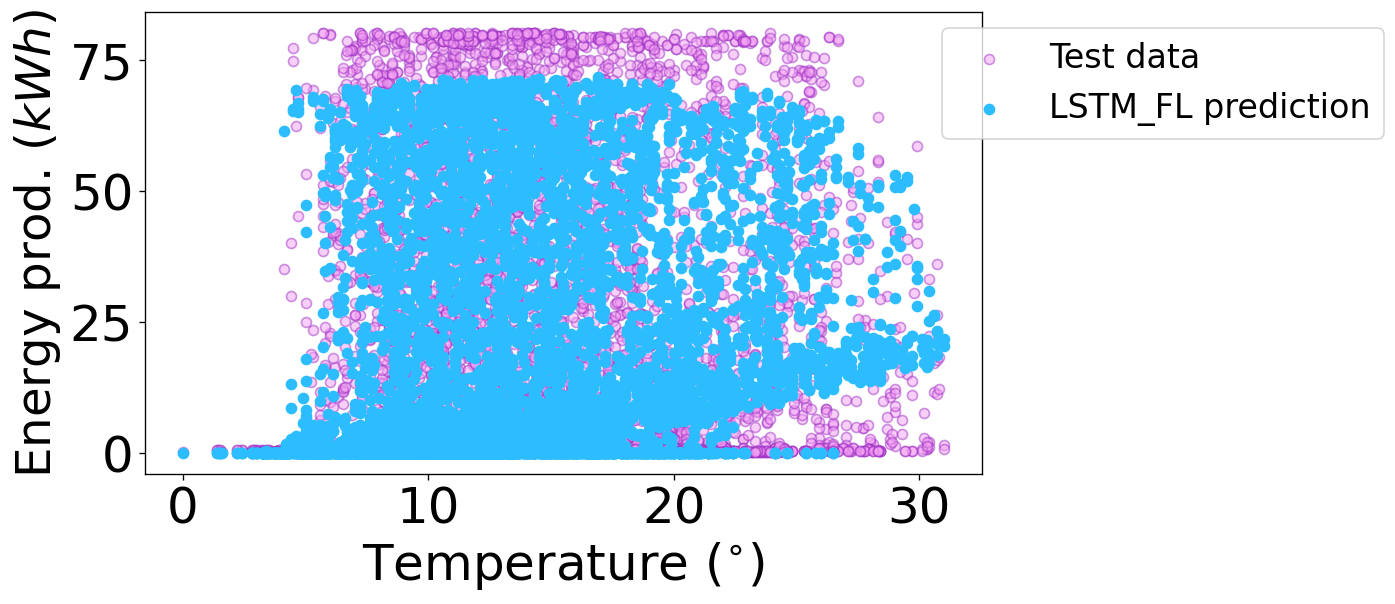

In [156]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test_original))[:,4], y=(Y_test_original), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test_original))[:,4], y=Y_predict_fl_2_prosum_1_vCPU, color="#2CBDFE", linewidth=1, label='LSTM_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_fl_2_prosum_1_cor_prediction.png", format="png", bbox_inches="tight")

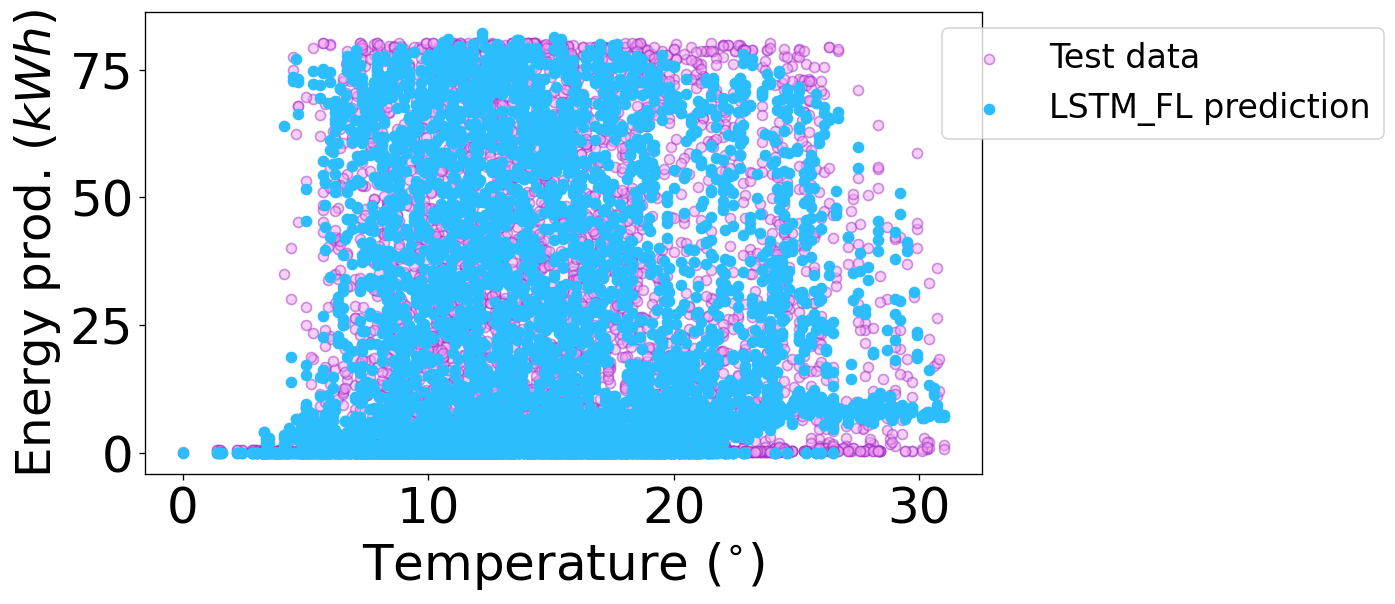

In [157]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test_original))[:,4], y=(Y_test_original), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test_original))[:,4], y=Y_predict_fl_4_prosum_1_vCPU, color="#2CBDFE", linewidth=1, label='LSTM_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_fl_4_prosum_1_cor_prediction.png", format="png", bbox_inches="tight")

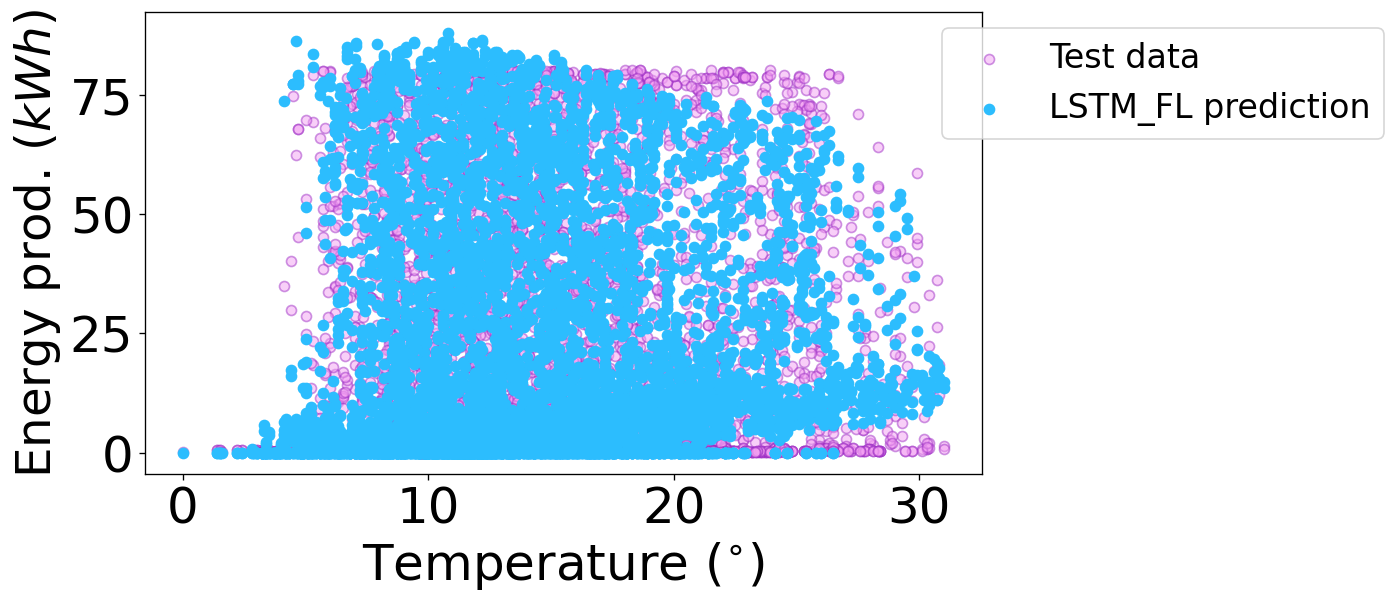

In [158]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test_original))[:,4], y=(Y_test_original), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test_original))[:,4], y=Y_predict_fl_4_prosum_4_vCPU, color="#2CBDFE", linewidth=1, label='LSTM_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_fl_4_prosum_12_cor_prediction.png", format="png", bbox_inches="tight")

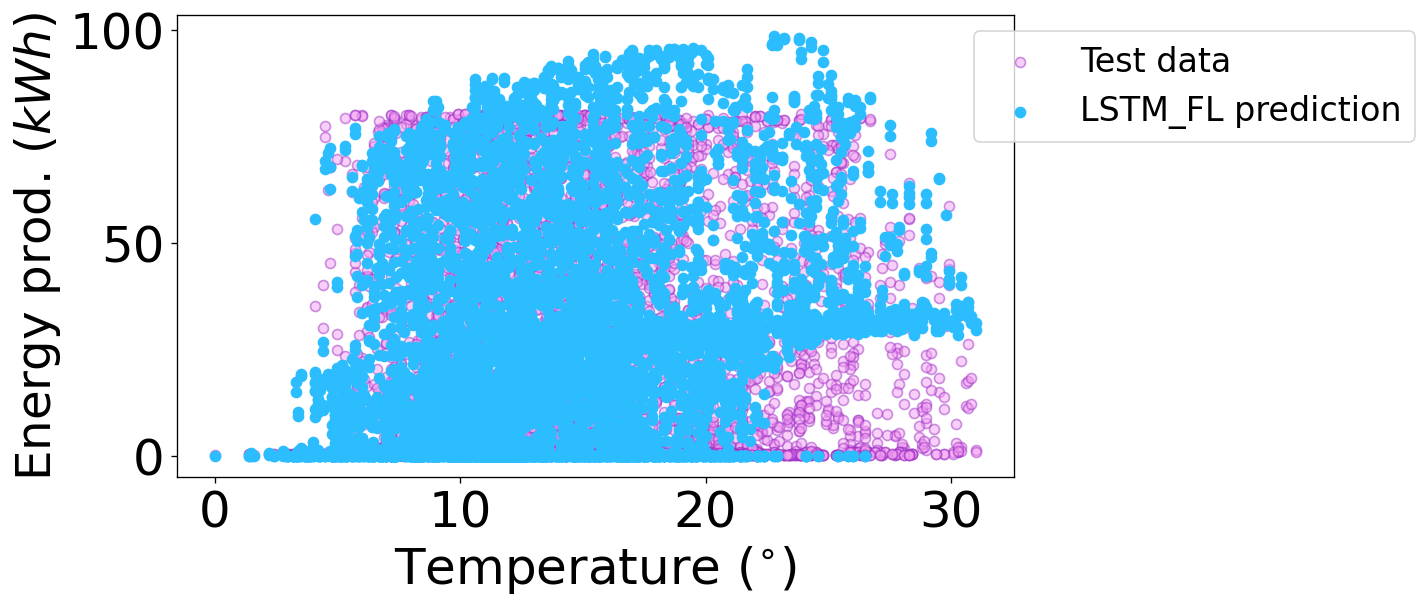

In [159]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test_original))[:,4], y=(Y_test_original), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test_original))[:,4], y=Y_predict_fl_6_prosum_6_vCPU, color="#2CBDFE", linewidth=1, label='LSTM_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_fl_6_prosum_6_cor_prediction.png", format="png", bbox_inches="tight")

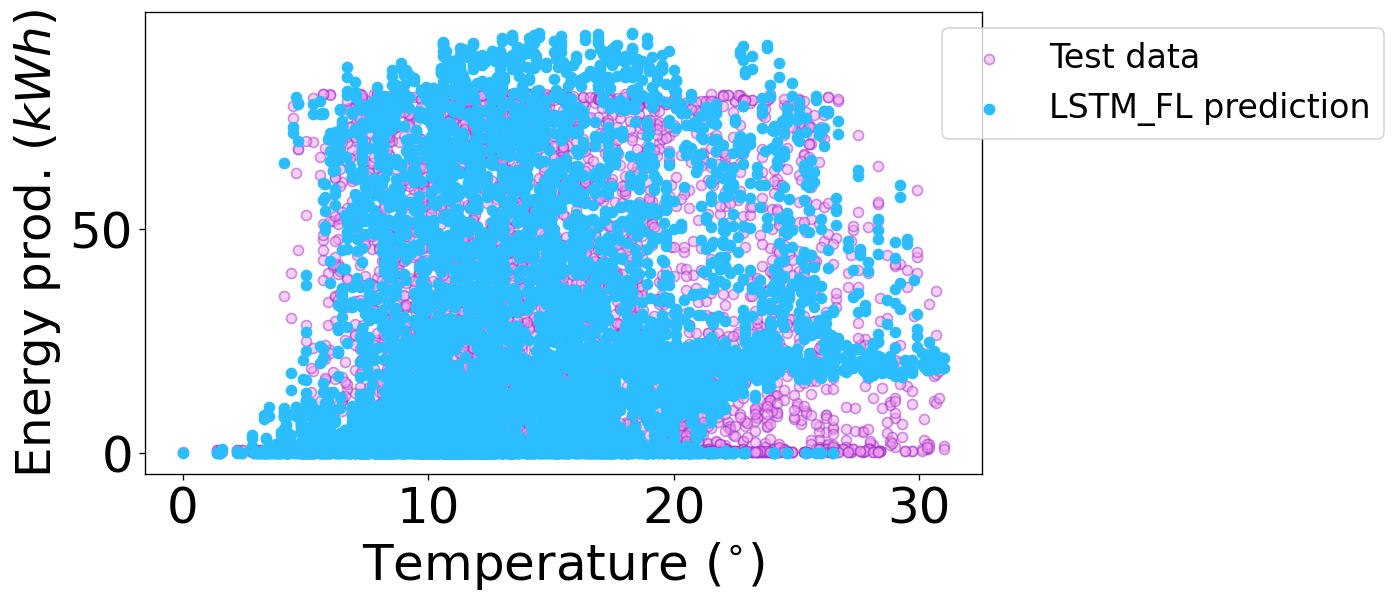

In [160]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test_original))[:,4], y=(Y_test_original), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test_original))[:,4], y=Y_predict_fl_8_prosum_8_vCPU, color="#2CBDFE", linewidth=1, label='LSTM_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_fl_8_prosum_8_cor_prediction.png", format="png", bbox_inches="tight")

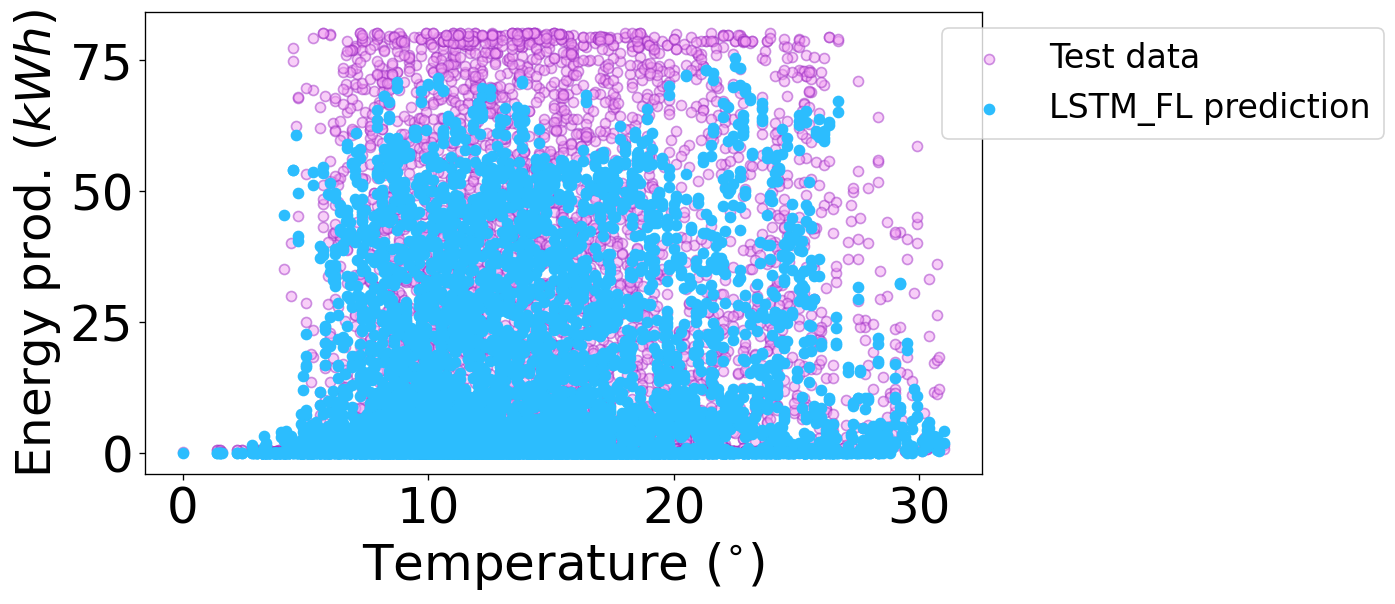

In [161]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test_original))[:,4], y=(Y_test_original), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test_original))[:,4], y=Y_predict_fl_10_prosum_10_vCPU, color="#2CBDFE", linewidth=1, label='LSTM_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_fl_10_prosum_10_cor_prediction.png", format="png", bbox_inches="tight")

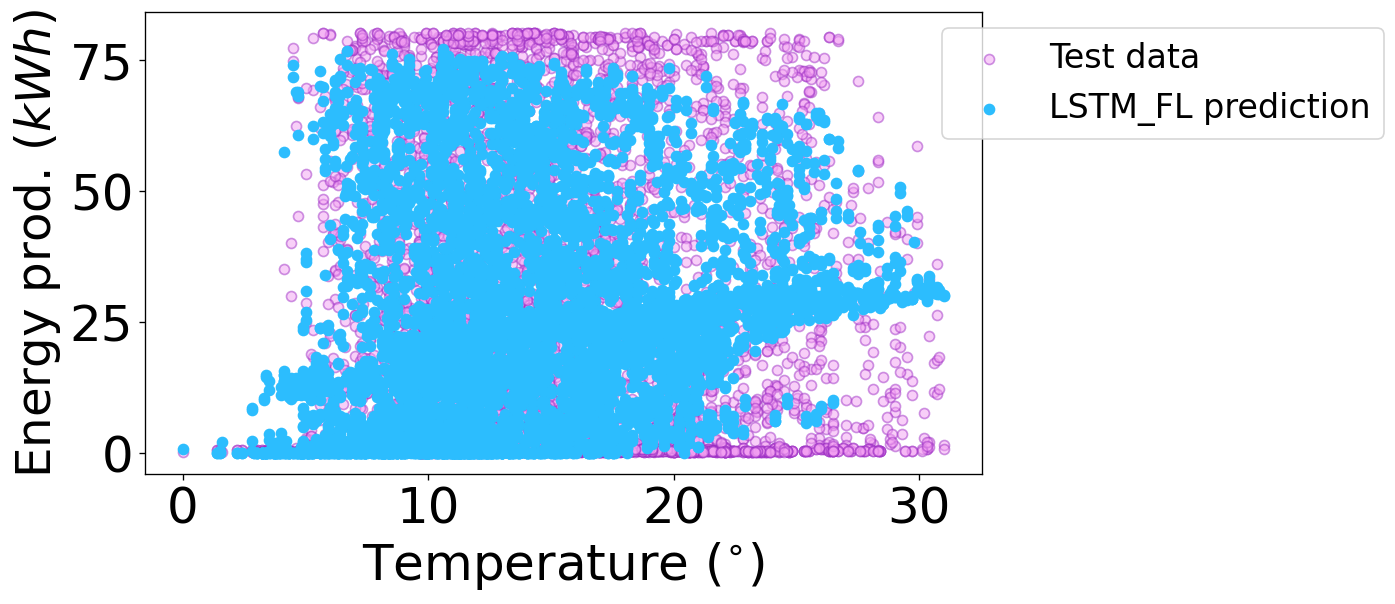

In [162]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test_original))[:,4], y=(Y_test_original), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test_original))[:,4], y=Y_predict_fl_10_prosum_8_vCPU, color="#2CBDFE", linewidth=1, label='LSTM_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_fl_10_prosum_8_cor_prediction.png", format="png", bbox_inches="tight")

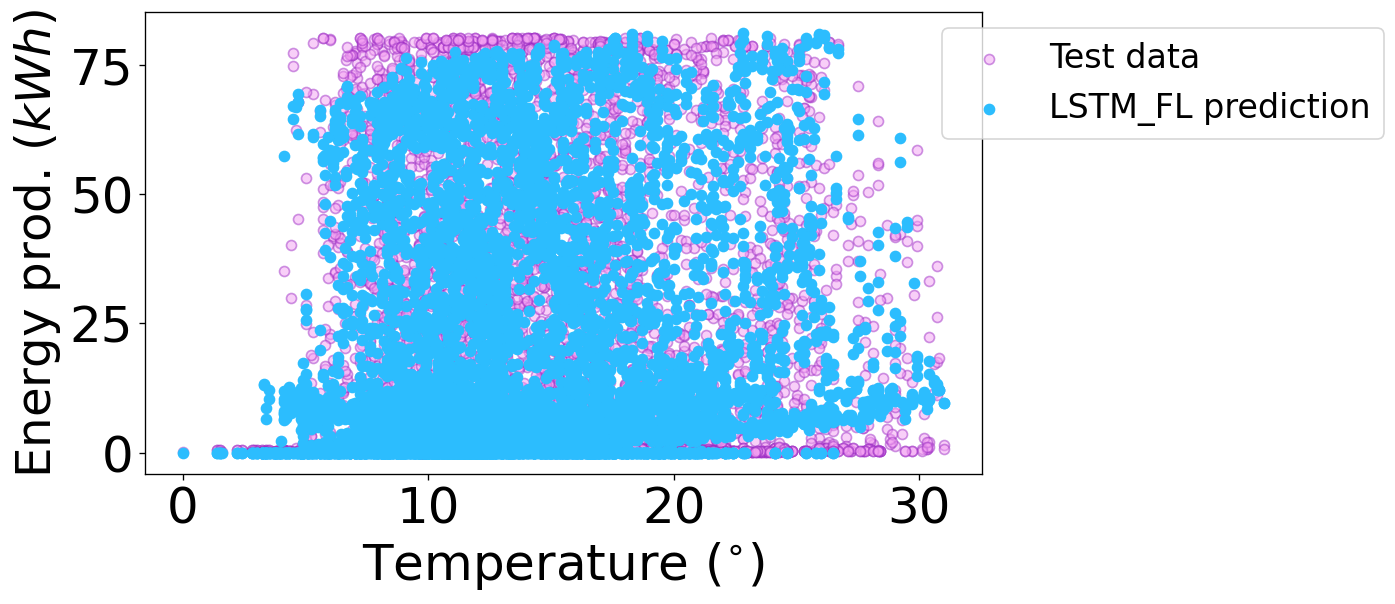

In [163]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test_original))[:,4], y=(Y_test_original), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test_original))[:,4], y=Y_predict_fl_12_prosum_12_vCPU, color="#2CBDFE", linewidth=1, label='LSTM_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_fl_12_prosum_12_cor_prediction.png", format="png", bbox_inches="tight")

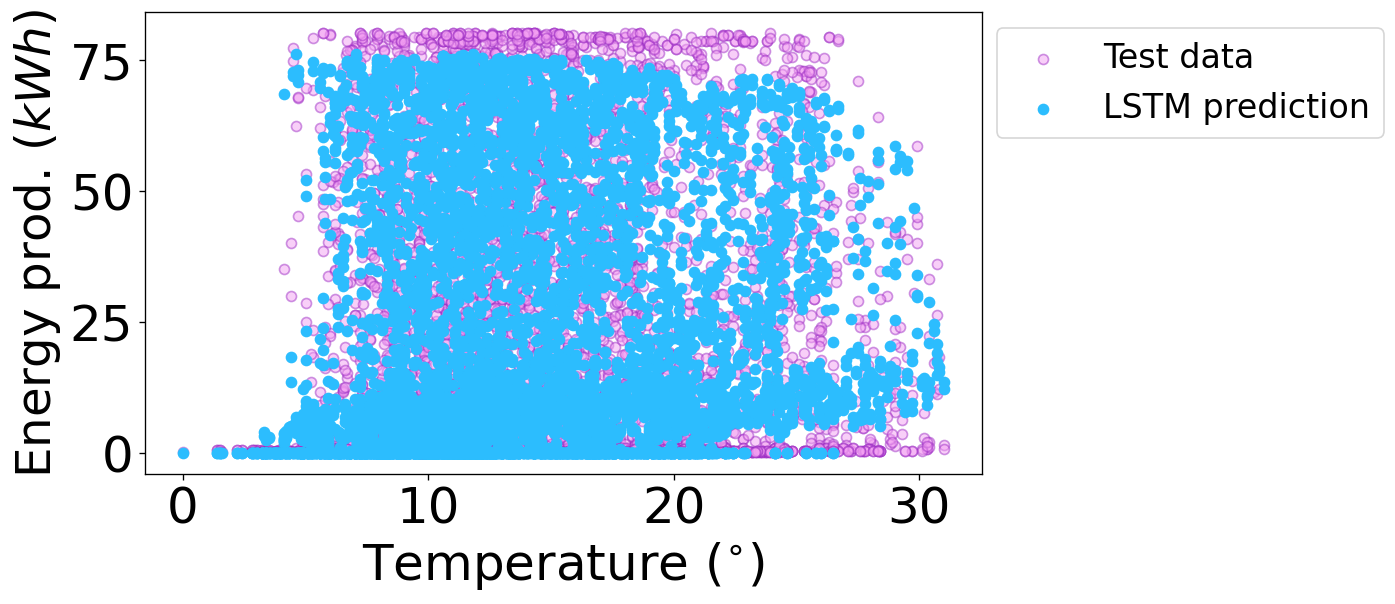

In [164]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=X_test_original[:,4], y=Y_test_original, color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=X_test_original[:,4], y=Y_predict_lstm, color="#2CBDFE", linewidth=1, label='LSTM prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("lstm_prediction.png", format="png", bbox_inches="tight")

In [165]:
mae = mean_absolute_error(Y_test_original, Y_predict_fl_4_prosum_1_vCPU)
mse = mean_squared_error(Y_test_original, Y_predict_fl_4_prosum_1_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_fl_4_prosum_1_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 6.8717147496405175
MSE : 130.37502157192898
RMSE: 11.418188191299397
R2  : 0.81


In [166]:
mae = mean_absolute_error(Y_test_original, Y_predict_fl_4_prosum_4_vCPU)
mse = mean_squared_error(Y_test_original, Y_predict_fl_4_prosum_4_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_fl_4_prosum_4_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 8.536369398566867
MSE : 166.44554175436076
RMSE: 12.901377513830093
R2  : 0.76


In [167]:
mae = mean_absolute_error(Y_test_original, Y_predict_fl_6_prosum_6_vCPU)
mse = mean_squared_error(Y_test_original, Y_predict_fl_6_prosum_6_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_fl_6_prosum_6_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 11.916765145624439
MSE : 268.546858758407
RMSE: 16.387399389726454
R2  : 0.61


In [168]:
mae = mean_absolute_error(Y_test_original, Y_predict_fl_8_prosum_8_vCPU)
mse = mean_squared_error(Y_test_original, Y_predict_fl_8_prosum_8_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_fl_8_prosum_8_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 10.92281271729115
MSE : 228.2360300324582
RMSE: 15.107482584218266
R2  : 0.67


In [169]:
mae = mean_absolute_error(Y_test_original, Y_predict_fl_10_prosum_8_vCPU)
mse = mean_squared_error(Y_test_original, Y_predict_fl_10_prosum_8_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_fl_10_prosum_8_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 13.579804138604402
MSE : 300.775313993558
RMSE: 17.342875020986515
R2  : 0.57


In [170]:
mae = mean_absolute_error(Y_test_original, Y_predict_fl_10_prosum_10_vCPU)
mse = mean_squared_error(Y_test_original, Y_predict_fl_10_prosum_10_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_fl_10_prosum_10_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 10.336880742783434
MSE : 297.26255949728517
RMSE: 17.241303880428685
R2  : 0.57


In [171]:
mae = mean_absolute_error(Y_test_original, Y_predict_fl_12_prosum_12_vCPU)
mse = mean_squared_error(Y_test_original, Y_predict_fl_12_prosum_12_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_fl_12_prosum_12_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 10.383585155146852
MSE : 232.32963294110817
RMSE: 15.242363102259052
R2  : 0.66


In [172]:
mae = mean_absolute_error(Y_test_original, Y_predict_lstm)
mse = mean_squared_error(Y_test_original, Y_predict_lstm)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_lstm)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 7.626786243942694
MSE : 132.52212291550427
RMSE: 11.511825351155405
R2  : 0.81


In [173]:
init_x_len = X.shape[0]
len_of_x_test_original = X_test.shape[0] - (24*4)

pd.DataFrame(np.hstack((
                        np.array(np.round((X_test)[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 6)), 
                        np.array(np.round((Y_test_original)[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_lstm[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_fl_1_prosum_1_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_fl_4_prosum_1_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_fl_4_prosum_4_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_fl_6_prosum_6_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_fl_8_prosum_8_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_fl_10_prosum_8_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_fl_10_prosum_10_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_fl_12_prosum_12_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1)
                       )), columns=['Month','Weekday(0=Monday,..., 6=Sunday)','Hour','Minute','Temperature','Ghi', 'Actual Energy (kW)',
                                     'Predicted Energy NO FL (kWh)', 'Predicted Energy_1_prosum_1_cor (kWh)', 'Predicted Energy_4_prosum_1_cor (kWh)', 
                                     'Predicted Energy_4_prosum_12_cor (kWh)', 'Predicted Energy_6_prosum_6_cor (kWh)','Predicted Energy_10_prosum_10_cor (kWh)',
                                     'Predicted Energy_10_prosum_8_cor (kWh)','Predicted Energy_10_prosum_10_cor (kWh)', 
                                     'Predicted Energy_12_prosum_12_cor (kWh)']).to_csv('pv_prediction_data_lstm_fl.csv', index=False)  # No index to be saved in the file

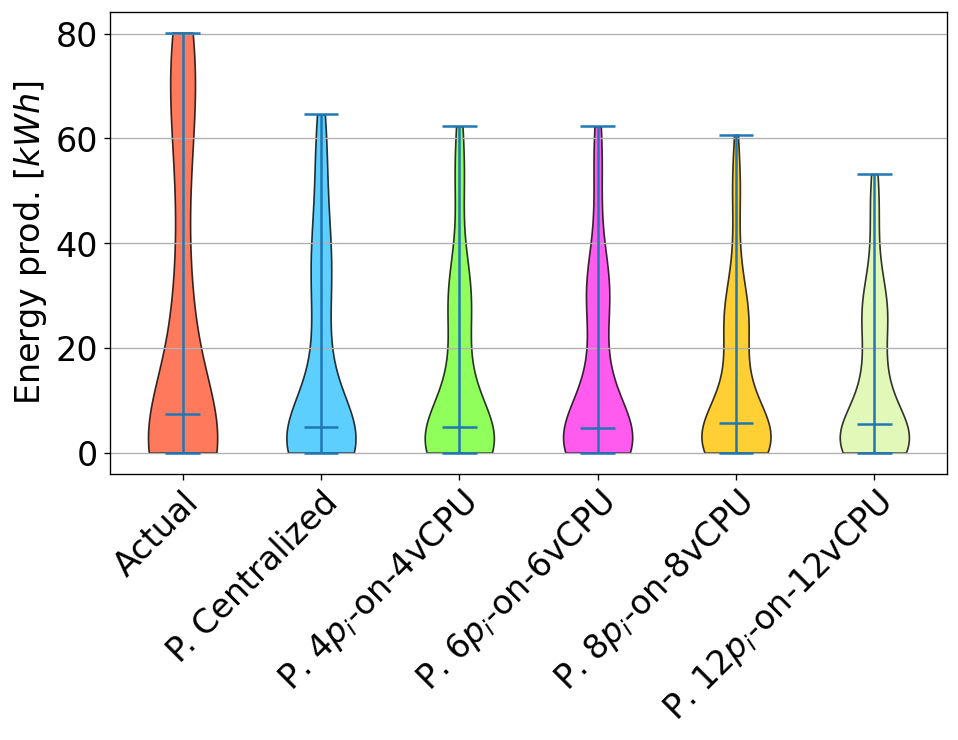

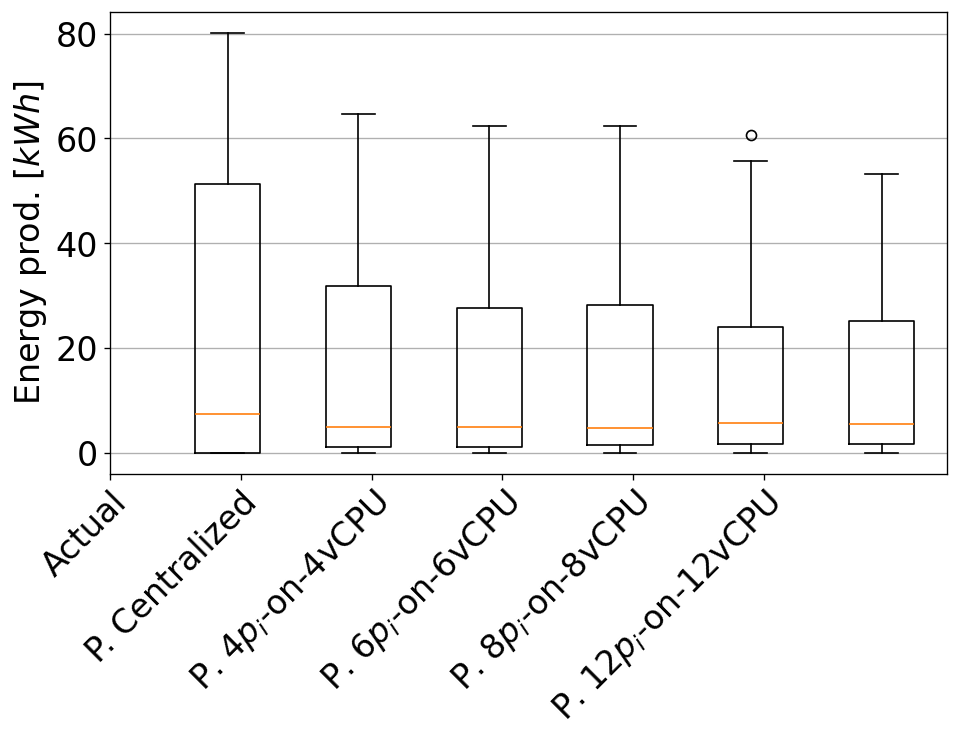

In [174]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs1 = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)
# Convert to DataFrame
df = pd.DataFrame({
    'Actual Energy (kW)': np.round(Y_test_original[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. Centralized (kWh)': np.round(Y_predict_lstm[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    #'P. 2$p_i$-on-1vCPU (kWh)': np.round(Y_predict_fl_1_prosum_1_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    #'P. 4$p_i$-on-1vCPU (kWh)': np.round(Y_predict_fl_4_prosum_1_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. 4$p_i$-on-12vCPU (kWh)': np.round(Y_predict_fl_4_prosum_4_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. 6$p_i$-on-6vCPU (kWh)': np.round(Y_predict_fl_6_prosum_6_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. 8$p_i$-on-8vCPU (kWh)': np.round(Y_predict_fl_8_prosum_8_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    #'P. 10$p_i$-on-8vCPU (kWh)': np.round(Y_predict_fl_10_prosum_8_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    #'P. 10$p_i$-on-10vCPU (kWh)': np.round(Y_predict_fl_10_prosum_10_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. 12$p_i$-on-12vCPU (kWh)': np.round(Y_predict_fl_12_prosum_12_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel()})
# plot violin plot
parts1 = axs1.violinplot(df, showmeans=False, showmedians=True)
# Define a list of colors (must match number of violins)
colors = ['#FF5733', '#33C3FF', '#75FF33', '#FF33EC', '#FFC300', '#DAF7A6', '#900C3F', '#581845', '#C70039', '#1D8348']
# Color each body of the violin
for i, pc in enumerate(parts1['bodies']):
    pc.set_facecolor(colors[i % len(colors)])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
# adding horizontal grid lines
axs1.yaxis.grid(True)
axs1.set_xticks([y+1 for y in range((df).shape[1])],
                  labels=['Actual', 'P. Centralized', #'P. 2$p_i$-on-1vCPU', 'P. 4$p_i$-on-1vCPU', 
                          'P. 4$p_i$-on-4vCPU', 'P. 6$p_i$-on-6vCPU',
                          'P. 8$p_i$-on-8vCPU', #'P. 10$p_i$-on-8vCPU', 'P. 10$p_i$-on-10vCPU', 
                          'P. 12$p_i$-on-12vCPU'],
                          rotation=70, fontsize=20)
#axs1.tick_params(axis='y', labelsize=20)
axs1.set_ylabel('Energy prod. [$kWh$]', fontsize=20)
plt.setp(axs1.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.savefig("violinplot_lstm_fl.pdf", format="pdf", bbox_inches="tight")

# plot box plot
fig, axs2 = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)
axs2.boxplot(df)
axs2.yaxis.grid(True)
axs2.set_xticks([y+0.1 for y in range((df).shape[1])],
                  labels=['Actual', 'P. Centralized', #'P. 2$p_i$-on-1vCPU', 'P. 4$p_i$-on-1vCPU', 
                          'P. 4$p_i$-on-4vCPU', 'P. 6$p_i$-on-6vCPU',
                          'P. 8$p_i$-on-8vCPU', #'P. 10$p_i$-on-8vCPU', 'P. 10$p_i$-on-10vCPU', 
                          'P. 12$p_i$-on-12vCPU'],
                          rotation=70, fontsize=20)
#axs2.set_yticks(fontsize=20)
axs2.set_ylabel('Energy prod. [$kWh$]', fontsize=20)
plt.setp(axs2.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.savefig("boxplot_lstm_fl.pdf", format="pdf", bbox_inches="tight")